-----
#<center> **Clustering sobre Mall Customers**
----



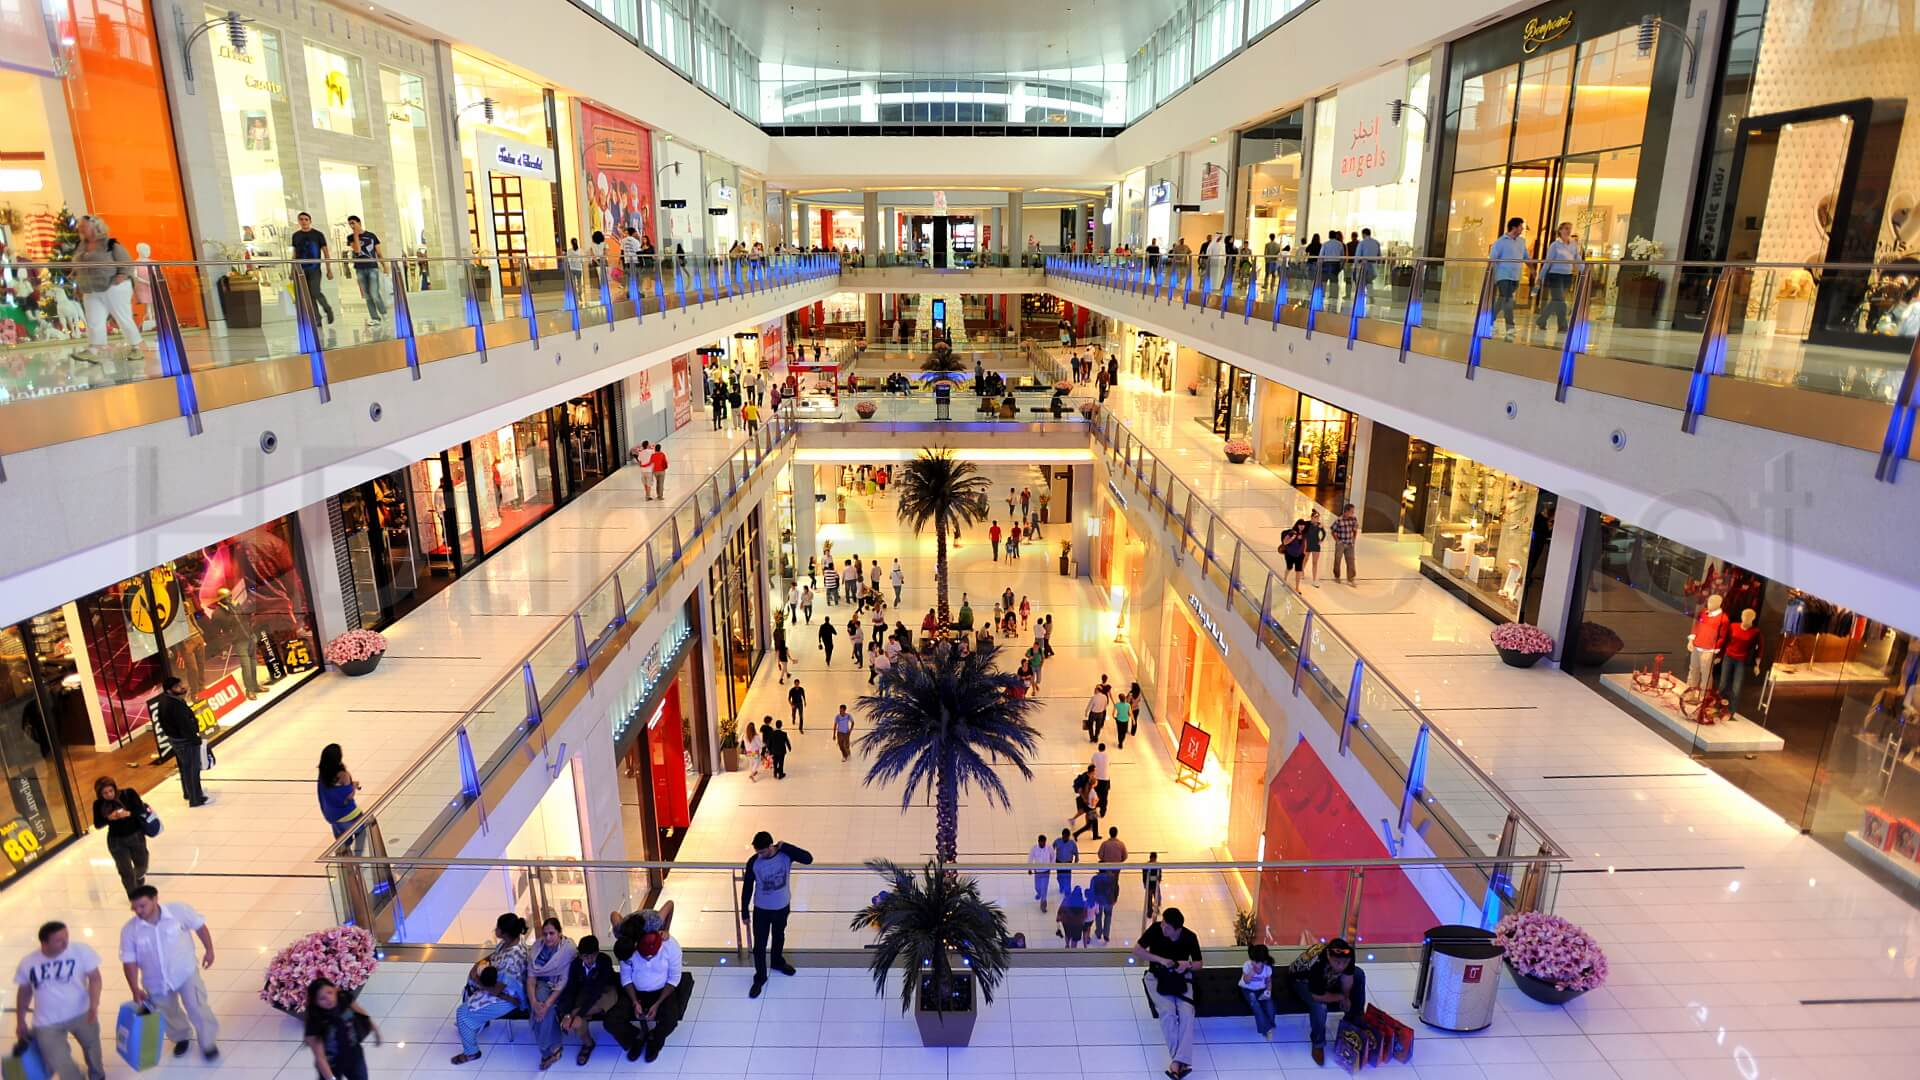

In [1]:
!pip install wget
!pip install validclust

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=24d54c0e970db9168767375b751b26941cc32869aecb4c98c74c52f47fe1de7b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Comenzamos con obtener el dataset que fue subido por nosotros a github para un acceso mas sencillo. (link al [dataset](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python?select=Mall_Customers.csv))

In [8]:
# montar la unidad de google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [15]:
!ls -lai '/content/gdrive/MyDrive/Colab Notebooks/DUIA/'

total 21
109 drwx------ 2 root root 4096 Jun  3 22:54  2021
116 -rw------- 1 root root  129 Aug 16 01:44  Mall_Customers.csv
108 drwx------ 2 root root 4096 Apr 29 23:17 'Módulo #1'
107 drwx------ 2 root root 4096 May  4 00:45 'Módulo #2'
110 drwx------ 2 root root 4096 Jun 12 12:31 'Módulo #3'
111 drwx------ 2 root root 4096 Aug  7 12:43 'Módulo #4'


In [16]:
# montar la unidad de google drive
# from google.colab import drive
# drive.mount('/content/gdrive/')

# crear las carpetas necesarias
from os import makedirs, path
import wget
datasets_folder = '/content/gdrive/MyDrive/Colab Notebooks/DUIA/'
makedirs(datasets_folder, exist_ok=True)

# cambio al directorio donde esta el csv --> para poder hacer esto hay que activar google drive desde el icono de la carpeta que esta a la izquierda de este codigo
%cd /content/gdrive/MyDrive/Colab Notebooks/DUIA/

filename = 'Mall_Customers.csv'
dataset_url = 'https://raw.githubusercontent.com/TomasCast/datasets/main/Mall_Customers.csv'

if not path.exists(filename):  # descargar solamente si no existe
  wget.download(dataset_url, filename)
  print('Dataset descargado')
else:
  print('El archivo {} ya existe.'.format(filename))

/content/gdrive/MyDrive/Colab Notebooks/DUIA
El archivo Mall_Customers.csv ya existe.


In [18]:
# imports
#from pandas_profiling import ProfileReport
import pandas as pd

# abro el archivo csv con pandas
data = pd.read_csv('/content/Mall_Customers.csv')

# chequeo si hay valores faltantes
print('El dataset contiene {} valores faltantes'.format(data.isnull().sum().sum()))

# visualizo los datos
data

El dataset contiene 0 valores faltantes


CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]

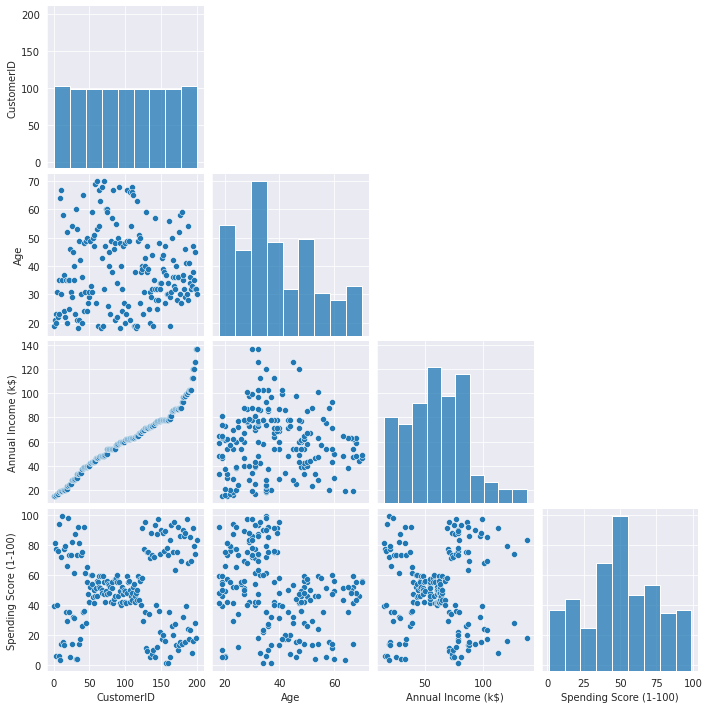

<Figure size 864x720 with 0 Axes>

In [21]:
# Visualizacion de las distribuciones de a pares 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

pairplot = sns.pairplot(data)
pairplot.map_upper(hide_current_axis)
plt.show()

# Visualizacion y Preparacion del Dataset

Podemos ver que el dataset contiene 5 atributos, de los cuales salvo Genero (que es categorico) son todos numericos. Es necesario que algunos atributos sean transformados para que los algoritmos de agrupamiento puedan funcionar correctamente. 

* *Gender*: Como podemos ver, el genero es un atributo nominal con dos valores podibles: Male y Female. Estos valores son de tipo 'String', y es conveniente llevarlos a una codificacion numerica, por ejemplo 0 y 1. Aun asi, este tipo de codificacion tiene un problema: Al ser representado por valores numericos, el algoritmo podria considerar que se trata de un atributo ordinal (es decir, considerar que el 0 es menor que el 1). Es por esto que quizas seria conveniente realizar una codificacion por *OneHotEncoding*, agregando una columna por cada valor de este atributo y asignarle un 1 a la columna "Male" o "Female" segun corresponda. Aun asi, se tomo la decision utilizar codificacion numerica (1 y 0) porque no tiene demasiado sentido agregar una columna mas para representar solo valores, con una columna alcanza. Ademas el problema de la ordinalidad persiste aunque agregaramos una columna. 

* *CustomerID*: Este atributo representa un identificador unico para cada consumidor. Puede deducire que este no es un atributo que tenga relevancia a la hora de decidir el agrupamiento de cada instancia, con lo que puede obviarse. De todas formas, es posible que haya alguna semantica de asignacion de estos numeros (por ejemplo, el orden en el que ingresan los consumidores al establecimiento), con lo que podria no eliminarase y evaluar los reultados considerandolo.

* *Age*: Indica la edad del consumidor, y esta entre 18 y 70 años. Se realizara una normalizacoin min-max sobre exte atributo.

* *Anual Income*: En este atributo se especifica el ingreso anual de cada comparador. Sobre este atributo tambien se realizara una normalizacion min-max

* *Spending Score*: Los valores de este atributo muestran un puntaje de gasto que depende de las compras que han hecho los consumidores. Va desde 0 a 100 y claramente es un atributo relevante a la hora de hacer el agrupamiento. Este es otro caso en el que se justifica aun mas realizar una normalizacion min-max, porque sabemos exactamente que valores comprenden el rango. 

Se realizo la normalizacion min-max de los 3 atributos anteriores, porque son numericos y es conveniente que todos ellos esten en un mismo rango (de 0 a 1) para que el algoritmo de clustering funcione de una manera mas acertada.

Cabe destacar que el conjunto de datos **no presenta valores faltantes** en ningun atributo, con lo que no hace falta realizar un tratamiento al respecto.

In [22]:
# Preparacion de los datos
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

def min_max_scaling(data):
    return (data - data.min())/(data.max() - data.min())

# - Atrbuto CustomerID
X = data.drop('CustomerID', axis='columns') # eliminamos la columna 

# - Atrbuto Gender
l_e = LabelEncoder()
gender_encoded = l_e.fit_transform(X['Gender'])
X['Gender'] = gender_encoded # Male --> 1 , Female --> 0


# - Atrbuto Age
X['Age'] = min_max_scaling(X['Age']) 

# - Atrbuto Anual Income
X['Annual Income (k$)'] = min_max_scaling(X['Annual Income (k$)'])

# - Atrbuto Spending score
X['Spending Score (1-100)'] = min_max_scaling(X['Spending Score (1-100)']) #DUDA: En el ejemplo que vimos en clase, nacho normaliza con min-max en base a TODA la matriz X. Poruqe?

X

Gender       Age  Annual Income (k$)  Spending Score (1-100)
0         1  0.019231            0.000000                0.387755
1         1  0.057692            0.000000                0.816327
2         0  0.038462            0.008197                0.051020
3         0  0.096154            0.008197                0.775510
4         0  0.250000            0.016393                0.397959
..      ...       ...                 ...                     ...
195       0  0.326923            0.860656                0.795918
196       0  0.519231            0.909836                0.275510
197       1  0.269231            0.909836                0.744898
198       1  0.269231            1.000000                0.173469
199       1  0.230769            1.000000                0.836735

[200 rows x 4 columns]

# Clustering con K-Means

El algoritmo de clustering elegido sera K-Means. Esto es porque no tiene sentido aplicar el clustering aglomerativo en esete dataset, dado que justamente cada una de las instancias no tienen una 'identificacion relevante' como en el caso de los paises visto en la teoria. 


---


Ahora que tenemos los datos listos para ser usados, es momento de elegir un K correcto para aplicar el algoritmo de **KMeans** sobre los mismos. Para esto, inicialmente haremos uso del **Elbow Plot**, que nos permitira ver la evolucion de las distancias respecto de las variaciones en K. 

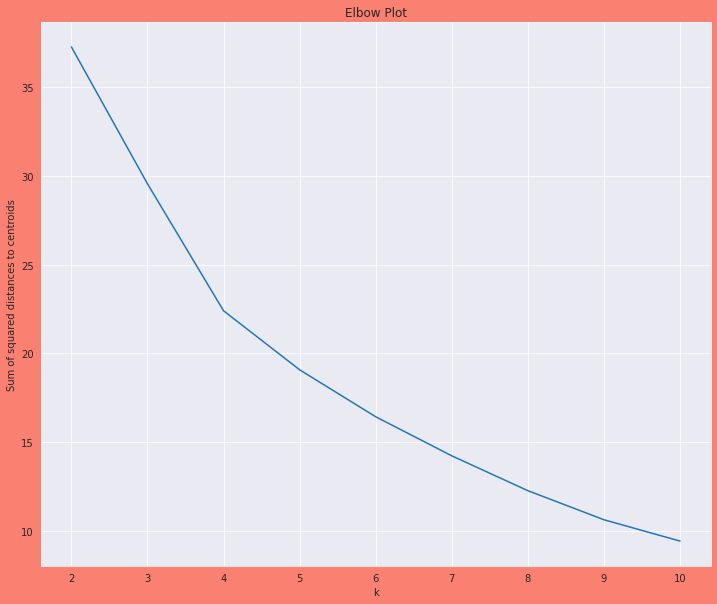

In [29]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np

def elbow_plot(X, n):
  '''
  Imprimo el Elbox plot para un dataset X dado y K={2, ..., n}
  '''
  # genero las particiones para diferentes valores de k, desde 1 a n
  kMeansVar = [KMeans(n_clusters=k).fit(X) for k in range(2, n+1)]
  # extraigo la suma de distancias entre cada muestra y los centroides
  sum_of_squared_distances = [km.inertia_ for km in kMeansVar]
  return sum_of_squared_distances

# recupero la suma de distancias cuadradas para valores de k de 2 a 10
N = 10
sum_of_squared_distances = elbow_plot(X, N)

fig, ax = plt.subplots(figsize=(12,10),facecolor='salmon')
ax.plot(sum_of_squared_distances)
ax.grid(True)
ax.set_title('Elbow Plot')
ax.set_xlabel('k')
ax.set_xticklabels(np.arange(1,N+1))
ax.set_ylabel('Sum of squared distances to centroids')
plt.show()

Mirando la curva, parece ser que es acertado tomar un K=4. Aun asi, la curva se muestra bastante lineal, con lo que miraremos otros indices que nos den un poco mas de informacion respecto de los reslutados que se obtienen al variar el K. Estos indices seran los siguientes:

* El **DB-Score** (o Davies-Bouldin Index) nos da informacion respecto de la separacion entre clusters, y sobre sus densidades. Al estar calculado en base al promedio de las dispersiones y distancias entre los clusters, **cuanto mas bajo sea su valor, mejor sera la calidad del clustering en ese sentido**. 

* El **Dunn Index** nos da informacion similar al DB-Score, porque nos habla de la diferencia entre clusters y sus densidades. En este caso, al estar basado en la division entre la menor distancia entre centroides y el aximo de las distancias internasen el cluster, **cuanto mas alto sea su valor, mejor sera el clustering**. 

* Finalmente, el **Coeficiente de Silueta** tambien sigue con la misma idea, y su valor esta en el rango [-1; 1], sieendo 1 el mejor valor posible y -1 el peor. 



--------- K = 2 ---------
Davies-Bouldin Score: 0.8172534497318455
Dunn Index: 0.7021114535656064
Avg Silhouette Index 0.5194624832665107
--------- K = 3 ---------
Davies-Bouldin Score: 0.9766387635039173
Dunn Index: 0.06525608686530524
Avg Silhouette Index 0.45835255811254255
--------- K = 4 ---------
Davies-Bouldin Score: 1.1399557416618764
Dunn Index: 0.06880472438150301
Avg Silhouette Index 0.36416575223390624
--------- K = 5 ---------
Davies-Bouldin Score: 1.0023045721982866
Dunn Index: 0.08774265534461399
Avg Silhouette Index 0.37073434917008075
--------- K = 6 ---------
Davies-Bouldin Score: 0.9536089348930874
Dunn Index: 0.10744652539425156
Avg Silhouette Index 0.37737920515583256
--------- K = 7 ---------
Davies-Bouldin Score: 0.9213960619169556
Dunn Index: 0.08176663582256767
Avg Silhouette Index 0.38574303710255803
--------- K = 8 ---------
Davies-Bouldin Score: 0.9441940181877002
Dunn Index: 0.03310878192794956
Avg Silhouette Index 0.3894980333306256
--------- K = 9 -------

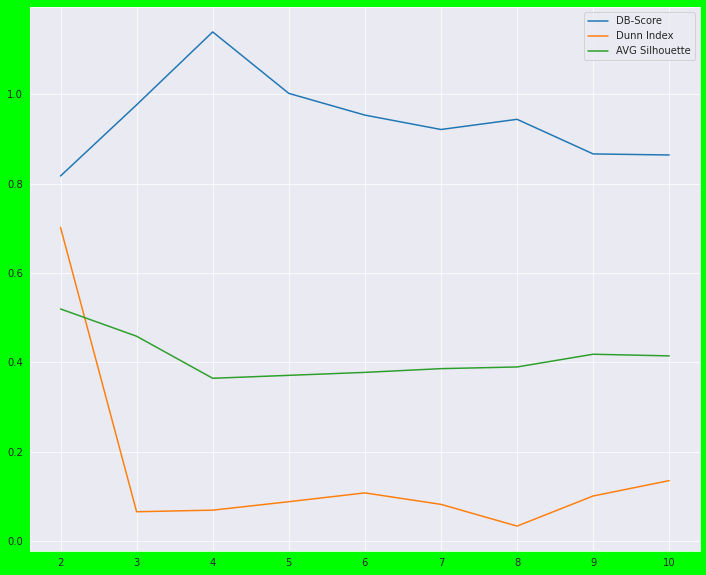

In [31]:
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples
from validclust import dunn

def show_kmeans_metrics(X):
    K = np.arange(2,11)

    db_score = []
    dunn_index = []
    avg_silhouette = []

    for k in K:
        print("--------- K = {} ---------".format(k))
        k_means = KMeans(n_clusters=k, verbose=0, random_state=10)
        k_means.fit(X)
        clusters = k_means.predict(X)

        db = davies_bouldin_score(X, clusters)
        db_score.append(db)
        print('Davies-Bouldin Score: {}'.format(db))

        di = dunn(pairwise_distances(X), clusters)
        dunn_index.append(di)
        print('Dunn Index: {}'.format(di))

        avg_sil = np.mean(silhouette_samples(X, clusters, metric='euclidean'))
        avg_silhouette.append(avg_sil)
        print('Avg Silhouette Index {}'.format(avg_sil))
    print('')
    plt.figure(figsize=(12,10),facecolor='lime')
    plt.plot(K, db_score, label="DB-Score")
    plt.plot(K, dunn_index, label="Dunn Index")
    plt.plot(K, avg_silhouette, label='AVG Silhouette')
    plt.legend()
    plt.show()

show_kmeans_metrics(X)

Al ver el grafico, podemos deducir que claramente el K=4 no es el mejor. En su lugar, parece ser que el K=2 sea el mejor, al maximizar los valores del indice de Dunn y el promedio del indice de silueta, y a la vez minimizar el DB-score. Esto puede estar sucediendo por el atributo Genero, que presenta solo dos valores y que la distancia entre ellos es de 1 (porque ahora estan representados por 0 y 1 segun sea Femenino o Masculino). Esto, combinado con que las distancias entre los valores del resto de los atributos sea casi siempre menor a 1, hace que el algoritmo quizas intente agrupar segun Genero.

Probaremos que resulados obtenemos con K=2, y veremos si esto realmente es asi con algunos scatter plots

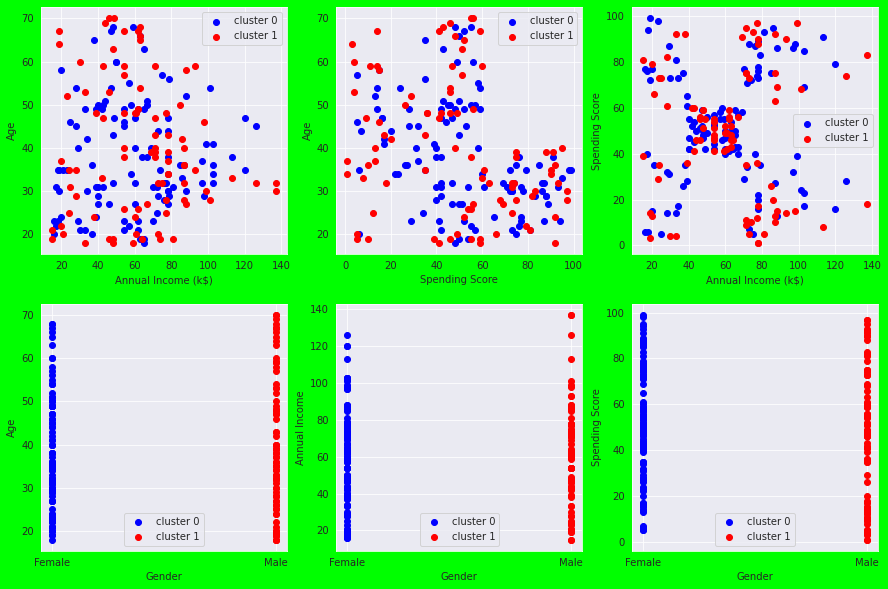

In [32]:
# probando con K=2
k_m = KMeans(n_clusters=2, random_state=10)
k_m.fit(X)
clusters_pred = k_m.predict(X)


# ----- Scatter Plots ------


data['cluster'] = clusters_pred
data_np = data.to_numpy()

fig, axes = plt.subplots(2,3, figsize=(15,10),facecolor='lime')


for cluster, color in enumerate(['blue', 'red']):

    #Annual Income vs Age
    axes[0,0].scatter(x=data_np[data_np[:,5] == cluster, 3], 
                    y=data_np[data_np[:,5] == cluster, 2], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[0,0].legend()
    axes[0,0].set_xlabel('Annual Income (k$)')
    axes[0,0].set_ylabel('Age')

    #Spending Score vs Age
    axes[0,1].scatter(x=data_np[data_np[:,5] == cluster, 4], 
                    y=data_np[data_np[:,5] == cluster, 2], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[0,1].legend()
    axes[0,1].set_xlabel('Spending Score')
    axes[0,1].set_ylabel('Age')

    #Annual Income vs Spending Score
    axes[0,2].scatter(x=data_np[data_np[:,5] == cluster, 3], 
                    y=data_np[data_np[:,5] == cluster, 4], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[0,2].legend()
    axes[0,2].set_xlabel('Annual Income (k$)')
    axes[0,2].set_ylabel('Spending Score')

    #Gender vs Age
    axes[1,0].scatter(x=data_np[data_np[:,5] == cluster, 1], 
                    y=data_np[data_np[:,5] == cluster, 2], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[1,0].legend()
    axes[1,0].set_xlabel('Gender')
    axes[1,0].set_ylabel('Age')

    #Gender vs Annual income
    axes[1,1].scatter(x=data_np[data_np[:,5] == cluster, 1], 
                    y=data_np[data_np[:,5] == cluster, 3], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[1,1].legend()
    axes[1,1].set_xlabel('Gender')
    axes[1,1].set_ylabel('Annual Income')

    #Gender vs Spending Score

    axes[1,2].scatter(x=data_np[data_np[:,5] == cluster, 1], 
                    y=data_np[data_np[:,5] == cluster, 4], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[1,2].legend()
    axes[1,2].set_xlabel('Gender')
    axes[1,2].set_ylabel('Spending Score')


plt.show()

Efectivamente, los graficos nos muestran que con un K=2, el algoritmo esta intentando separar primeramente por Genero (posiblemente por la cuestion de la distancia entre sus dos unicos valores). Esto, no nos favorece por dos cuestiones. La primera es que, al agrupar primero por genero, el agrupamiento en base al resto de las features queda en "segundo plano" y por ende, las muestras queden muy mezcaladas en cuanto al los valores de estos atributos. La segunda cuestion, y la mas obvia tambien, es que no nos interesa agrupar por genero. No tiene sentido, porque simplemente mirando los valores de este atributo podemos saber si es Masculino o Femenino. 

Definitivamente, este agrupamiento no es para nada util. Por esto, probaremos con eliminar el atributo Genero, y luego vamos a proceder a elegir el K mas acertado de la misma manera que lo hicimos antes

In [33]:
# - Eliminamos el atributo Gender
X = X.drop('Gender', axis='columns')

X

Age  Annual Income (k$)  Spending Score (1-100)
0    0.019231            0.000000                0.387755
1    0.057692            0.000000                0.816327
2    0.038462            0.008197                0.051020
3    0.096154            0.008197                0.775510
4    0.250000            0.016393                0.397959
..        ...                 ...                     ...
195  0.326923            0.860656                0.795918
196  0.519231            0.909836                0.275510
197  0.269231            0.909836                0.744898
198  0.269231            1.000000                0.173469
199  0.230769            1.000000                0.836735

[200 rows x 3 columns]

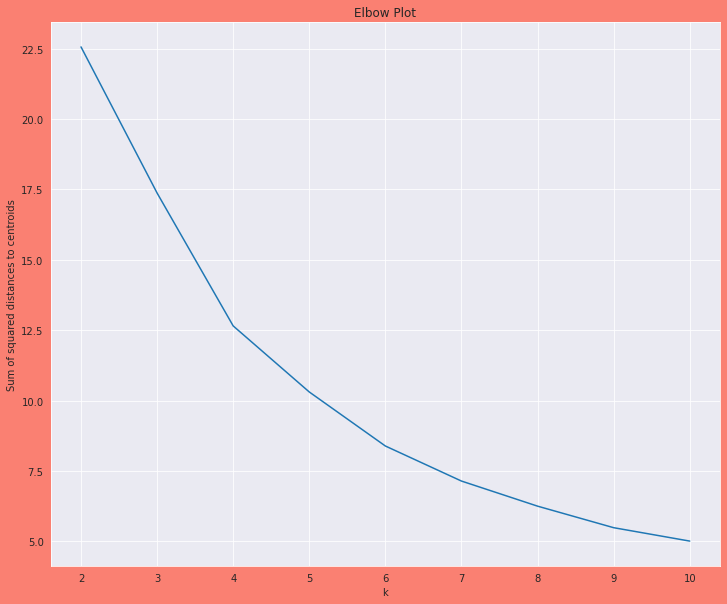

In [34]:
# recupero la suma de distancias cuadradas para valores de k de 2 a 10
N = 10
sum_of_squared_distances = elbow_plot(X, N)

fig, ax = plt.subplots(figsize=(12,10),facecolor='salmon')
ax.plot(sum_of_squared_distances)
ax.grid(True)
ax.set_title('Elbow Plot')
ax.set_xlabel('k')
ax.set_xticklabels(np.arange(1,N+1))
ax.set_ylabel('Sum of squared distances to centroids')
plt.show()

--------- K = 2 ---------
Davies-Bouldin Score: 1.1485007396260143
Dunn Index: 0.06880472438150242
Avg Silhouette Index 0.3652498066402899
--------- K = 3 ---------
Davies-Bouldin Score: 1.0513811648902303
Dunn Index: 0.048822190860872784
Avg Silhouette Index 0.36504262943838
--------- K = 4 ---------
Davies-Bouldin Score: 0.9706494236068249
Dunn Index: 0.05493552352367751
Avg Silhouette Index 0.39231920205572207
--------- K = 5 ---------
Davies-Bouldin Score: 0.8795479778890576
Dunn Index: 0.0621013321527705
Avg Silhouette Index 0.406117433070782
--------- K = 6 ---------
Davies-Bouldin Score: 0.8598857914357642
Dunn Index: 0.060733075611827086
Avg Silhouette Index 0.42309315456649116
--------- K = 7 ---------
Davies-Bouldin Score: 0.8050175023814082
Dunn Index: 0.07060585908104404
Avg Silhouette Index 0.4218009236648788
--------- K = 8 ---------
Davies-Bouldin Score: 0.8626155093520749
Dunn Index: 0.11593758807753157
Avg Silhouette Index 0.4164902264544964
--------- K = 9 ---------
D

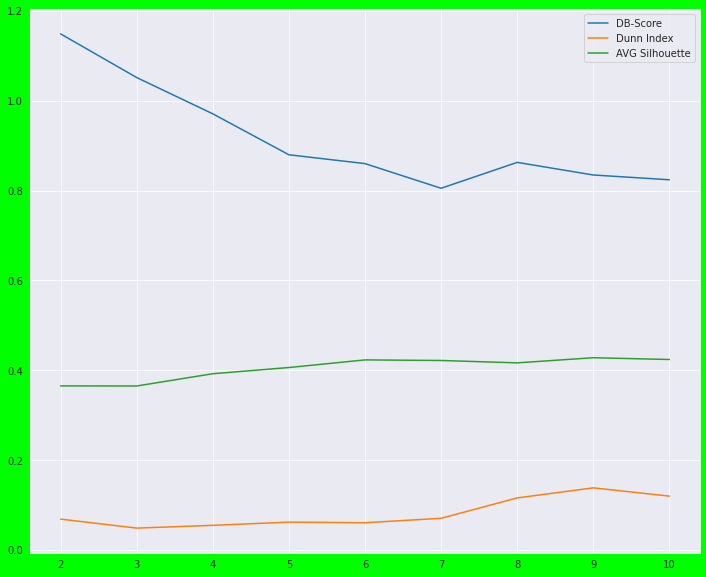

In [35]:
show_kmeans_metrics(X)

Nuevamente mirando el elbow plot y las metricas, podemos concluir con que un K=5 seria lo mas acertado. Esto es porque, sin irnos hacia un valor de  muy alto, minimizamos el DB-Score y maximizamos el Dunn Index y el promedio del indice de Silueta.

Ahora si, podemos esperar mejores resultados con este K al aplicar K-Means sobre los datos. A continuacion, entrenaremos el modelo con este hiperparametro y veremos los resultados con algunos graficos. 

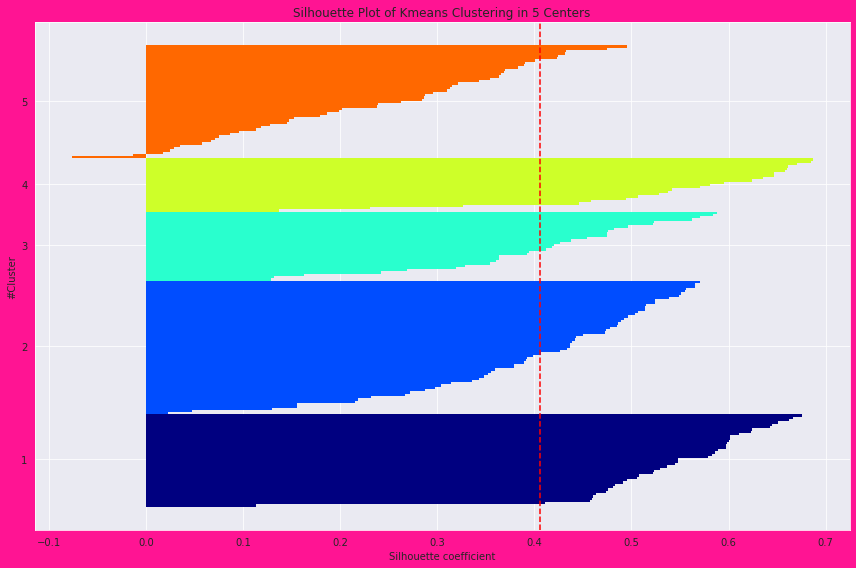

In [36]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=5, 
            init='k-means++', 
            max_iter=300,
            tol=1e-04,
            random_state=10)

clusters_pred = km.fit_predict(X)

cluster_labels = np.unique(clusters_pred)
n_clusters = cluster_labels.shape[0]

#calculo 
silhouette_vals = silhouette_samples(X, clusters_pred, metric='euclidean')

#grafico
y_ax_lower, y_ax_upper = 0, 0
yticks = []


plt.figure(figsize=(12,8),facecolor='deeppink')
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[clusters_pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.title('Silhouette Plot of Kmeans Clustering in 5 Centers')
plt.ylabel('#Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, clusters_pred, metric='euclidean'))

Silhouette Coefficient: 0.406


El coeficiente de Silhouette es de 0.406, este coeficiente se calcula utilizando la distancia media dentro del clúster y la distancia media del clúster más cercano. Un valor cercano a 1 nos indica que el objeto se corresponde bien con su propio clúster y no con sus vecinos. Los valores cercanos a cero indican grupos superpuestos y valores negativos indican que una muestra se ha asigando al grupo incorrecto.

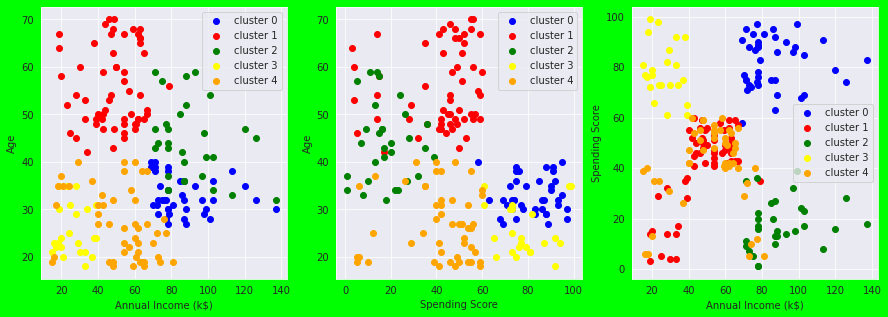

In [39]:

data['cluster'] = clusters_pred
data_np = data.to_numpy()

fig, axes = plt.subplots(1,3, figsize=(15,5),facecolor='lime')


for cluster, color in enumerate(['blue', 'red', 'green', 'yellow', 'orange']):

    #Annual Income vs Age
    axes[0].scatter(x=data_np[data_np[:,5] == cluster, 3], 
                    y=data_np[data_np[:,5] == cluster, 2], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[0].legend()
    axes[0].set_xlabel('Annual Income (k$)')
    axes[0].set_ylabel('Age')

    #Spending Score vs Age
    axes[1].scatter(x=data_np[data_np[:,5] == cluster, 4], 
                    y=data_np[data_np[:,5] == cluster, 2], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[1].legend()
    axes[1].set_xlabel('Spending Score')
    axes[1].set_ylabel('Age')

    #Annual Income vs Spending Score
    axes[2].scatter(x=data_np[data_np[:,5] == cluster, 3], 
                    y=data_np[data_np[:,5] == cluster, 4], 
                    c=color,
                    label='cluster {}'.format(cluster))
    axes[2].legend()
    axes[2].set_xlabel('Annual Income (k$)')
    axes[2].set_ylabel('Spending Score')



plt.show()




Estos graficos nos muestran que los clusters 0 y 3 son aquellos que mas spending score poseen (y por ende, mas nos interesan). En general, se puede apreciar lo siguiente:

 * **Segun el 3er grafico:** Cluster 0 y Cluster 3 Representan a los clusters que mas spending score tienen (aproximadamente de 60 a 100) y que se diferencian en ese mismo grafico por el ingreso anual (bajos, de 20 a 40 y altos de 80 a 140 respectivamente). 

* **Segun el 2do grafico:** Al analizar los clusters 0 y 3 (los que mayor spending score tienen) respecto de la edad, podemos ver que, para el cluster 0 la edad esta aproximadamente entre 28 y 40 años, mientras que para el cluster 3 estan entre aproximadamente 20 y 35 años.

Hay otros clusters que tambien nos interesa analizar. 
* Cluster 1 y Cluster 4 son aquellos consumidores que tienen spending score medio-bajo. En cuanto al cluster 1, se trata de aquellos que tienen aproximadamente mas de 41 años y con un ingreso anual de menos de 70 mil dolares. En el cluster 4, tenemos consumidores con edades de aproximadamente menos de 40 años y que generalmente tienen un ingreso anual de entre 40 y 60 mil dolares.

* Cluster 2: Este cluster corresponde a los consumidores que menos spending score tienen, y que por ende menos nos interesan. Se trata de aquellos que tienen edades generalmente de 40 hacia arriba, y que tienen ingresos anuales de mas de 70 mil dolares. 

Esto podra verse con mas detalle con **Box Plots** y **Violin Plots**, que se mostraran a continuacion


 ---- ----

**ESTO HABRIA QUE HACERLO COMO CONCLUSION AL FINAL, USANDO VALORES MAS CORRECTOS SEGUN VIOLIN PLOT**

En resumen, los consumiedores que mas nos interesan son los representados por los clusters 0 y 3:
* Cluster 0: Aquellos consumidores que tienen ingresos anuales de aproximadamente 75 a 140 (miles de dolares), que su edad este entre aproximadamente 26 y 40 años.

* Cluster 3: Consumidores con ingresos anuales de aproximadamente 20 a 40 mil dolares y con edades de aproximadamente entre 18 y 30 años. 


Luego, hay otros clusters que tambien pueden ser de interes inferior, porque presentan spending scores mas bajos. Estos son los clusters 1 y 4, que corresponden a los clientes que tienen spending score medio, y que quizas la empresa de ventas podria mejorar las estrategias de marketing sobre estos, para incentivar sus consumos. 



In [40]:
data['cluster'] = data['cluster'].replace({0: 'cluster 0', 1:'cluster 1', 2:'cluster 2',3:'cluster 3', 4:'cluster 4'})
data

CustomerID  Gender  ...  Spending Score (1-100)    cluster
0             1    Male  ...                      39  cluster 4
1             2    Male  ...                      81  cluster 3
2             3  Female  ...                       6  cluster 4
3             4  Female  ...                      77  cluster 3
4             5  Female  ...                      40  cluster 4
..          ...     ...  ...                     ...        ...
195         196  Female  ...                      79  cluster 0
196         197  Female  ...                      28  cluster 2
197         198    Male  ...                      74  cluster 0
198         199    Male  ...                      18  cluster 2
199         200    Male  ...                      83  cluster 0

[200 rows x 6 columns]

In [41]:
import plotly.express as px
import plotly.graph_objects as go

data_np = data.to_numpy()

fig = go.Figure()

fig.add_trace(go.Box(y=data_np[data_np[:,5] == 'cluster 0', 4], name='Cluster 0', marker_color = 'blue'))
fig.add_trace(go.Box(y=data_np[data_np[:,5] == 'cluster 1', 4], name='Cluster 1', marker_color = 'red'))
fig.add_trace(go.Box(y=data_np[data_np[:,5] == 'cluster 2', 4], name='Cluster 2', marker_color = 'green'))
fig.add_trace(go.Box(y=data_np[data_np[:,5] == 'cluster 3', 4], name='Cluster 3', marker_color = 'yellow'))
fig.add_trace(go.Box(y=data_np[data_np[:,5] == 'cluster 4', 4], name='Cluster 4', marker_color = 'orange'))


fig.update_layout(
    title= {'text':"BOXPLOT",
            'y':0.9, 'x':0.5,
            'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="#CLUSTER",
    yaxis_title="Spending Score (1-100)")
    
fig.show()

En este boxplot se puede analizar la distribución de la variable **Spending Score** a partir del agrupamiento realizado por el algoritmo Kmeans.

Vemos claramente que los clusters 0 y 3 tienen cierta similitud en el **Spending Score** con valores que oscilan entre 60 y 100. Si bien la mediana es algo superior en el clúster 0 ( una mediana de 83), el clúster 3 tiene una distribución marcadamente simétrica en su composición.

Para el resto de los clusters, todos se encuentran con un **Spending Score** por debajo de los 60 siendo el clúster 2 el que presenta las puntuaciones más bajas de los 5 clusters con una mediana de 16.5 en **Spending Score**.

In [42]:
fig = go.Figure()

fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 0', 3], name='Cluster 0', marker_color = 'blue',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 1', 3], name='Cluster 1', marker_color = 'red',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 2', 3], name='Cluster 2', marker_color = 'green',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 3', 3], name='Cluster 3', marker_color = 'yellow',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 4', 3], name='Cluster 4', marker_color = 'orange',box_visible=True,meanline_visible=True))

fig.update_layout(
    title= {'text':"VIOLINPLOT",
            'y':0.9, 'x':0.5,
            'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="#CLUSTER",
    yaxis_title="Annual Income (k$)")
    
fig.show()

El gráfico **Violin Plot** es una representación visual muy similar al del boxplot con el agregado del kernel density de cada lado de la figura.

Para el análisis de comparar y analizar la distribución de la variable **Annual Income** en cada clúster, vemos que no presenta grandes diferencias en los clústers 0 y 4 ya que la distribución es muy similar en ambos con una pequeña diferencia superior tanto en media como en mediana (90k y 87k respectivamente) para el clúster 2. Es decir, estos dos clusters son los que presentan la distribución más alta de Annual Income, sería el grupo de consumidores que se ubican con los ingresos anuales más altos.

Para el caso del clúster 3, claramente es muy notorio que corresponde a un clúster en donde los consumidores presentan los ingresos más bajos (entre unos 15k y 40k).



In [43]:
fig = go.Figure()

fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 0', 2], name='Cluster 0', marker_color = 'blue',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 1', 2], name='Cluster 1', marker_color = 'red',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 2', 2], name='Cluster 2', marker_color = 'green',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 3', 2], name='Cluster 3', marker_color = 'yellow',box_visible=True,meanline_visible=True))
fig.add_trace(go.Violin(y=data_np[data_np[:,5] == 'cluster 4', 2], name='Cluster 4', marker_color = 'orange',box_visible=True,meanline_visible=True))


fig.update_layout(
    title= {'text':"VIOLINPLOT",
            'y':0.9, 'x':0.5,
            'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="#CLUSTER",
    yaxis_title="AGE")
    
fig.show()

En esta última representación gráfica tenemos la distribución de la variable **Age** para los cinco clusters predecidos. 

Para el caso de los clusters 1 y 2, se tienen los grupos de consumidores con mayor rango de edad con una media de 56 años para el clúster 1 y un promedio de 44 años para el clúster 2. Para el clúster 2 las edades en ese grupo de consumidores se encuentran entre los 32 y 59 años. También podemos ver cierta asimetría positiva para ese clúster, lo que nos dice esto es que su media es mayor al valor de su mediana (43 años).

Para el clúster 0 tenemos a los consumidores con edades que se encuentran entre los 27 y 40 años. 

Finalmente el análisis que podemos darle a los restantes clusters 3 y 4, es que corresponden según el agrupamiento del algoritmo Kmeans a grupos de consumidores con las edades más bajas. El promedio de edad en el clúster 3 es de 25 años y de 27 años para el clúster 4. De estos últimos clusters vemos que el clúster 3 es el que presenta una distribución más homogénea en relación a las edades que lo definen.



# Conclusiones

Como conclusión, si nos interesa generar publicidad específica para los grupos que más spending score tienen (asumiendo que son esos quienes generan mayores ganancias) hay que apuntar a los clientes contenidos por los clusters 0 y 3:

* **Cluster 0:** Personas con edades que se ubican entre los 30 y 36 años, con ingresos de 74 a 94 mil dólares anuales.

* **Cluster 3:** Personas cuyo rango de edad están entre 21 y 30 años, con ingresos más bajos, específicamente de 18 mil a 33 mil dólares anuales. 

Si nos interesan los consumidores con spending score medio, se debería estudiar los clusters 1 y 4:

* **Cluster 1:** Personas con edades generalmente de 49 a 64 años, y con ingresos desde 39 a 60 mil dólares anuales.

* **Cluster 4:** Consumidores con edades que van generalmente desde 19 a 33 años, y que tienen ingresos anuales desde 41 mil a 64 mil dólares.

Finalmente, los consumidores con menor score, son los contenidos por el **cluster 2:** Aquellas personas de 36 a 47 años con ingresos desde 77 mil a 98 mil dólares anuales. 



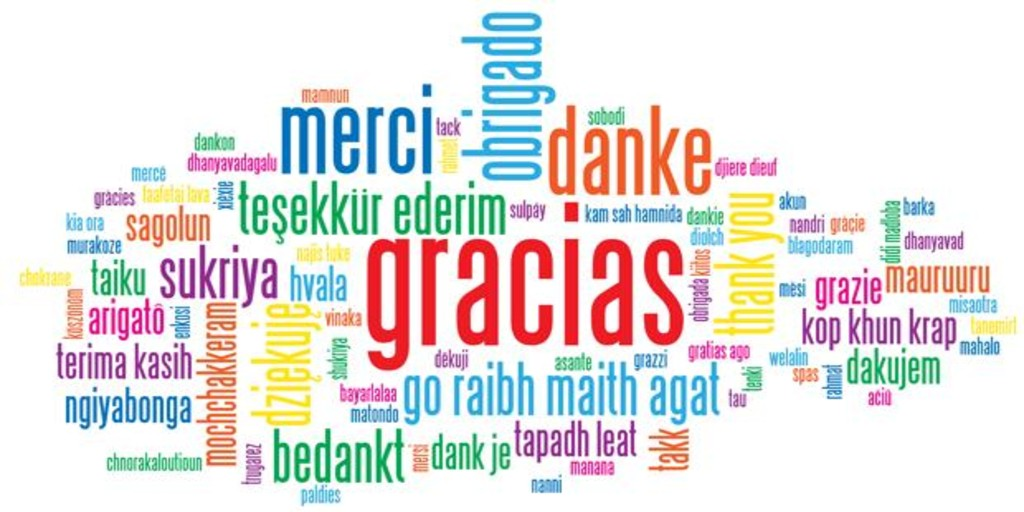